# 1. Introduction to object detection

This notebook is motivated by fast.ai's course.

As an introduction to object detection, I will train a neural network which will find the largest object in the image, and draw a bounding box around it.

In [1]:
%matplotlib inline

In [2]:
import torch
import voc
from pathlib import Path

Pick one

In [3]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

1. Let's take a look at the data

Note that I haven't rearranged the data from when I downloaded it on the [VOC website](http://host.robots.ox.ac.uk/pascal/VOC/). I downloaded the 2007 dataset. 

Showing VOC2007/Annotations/001388.xml


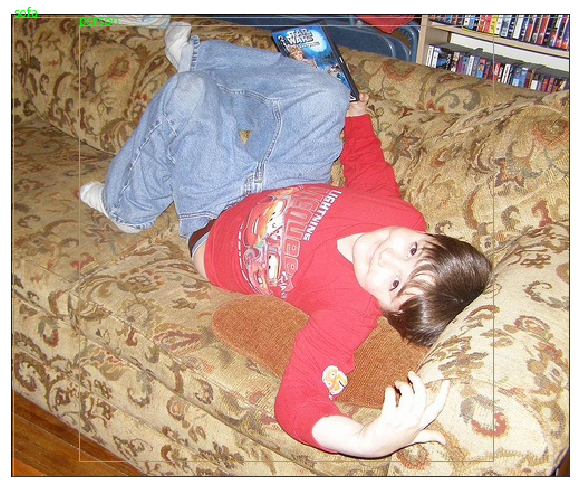

In [4]:
annotation = voc.utils.show_random_example(return_annotation=True)

For this exercise, we will only be recognizing the largest object in the image, so given the annotations, I want to find the largest object.

In [5]:
filtered = voc.utils.keep_largest_box(annotation)

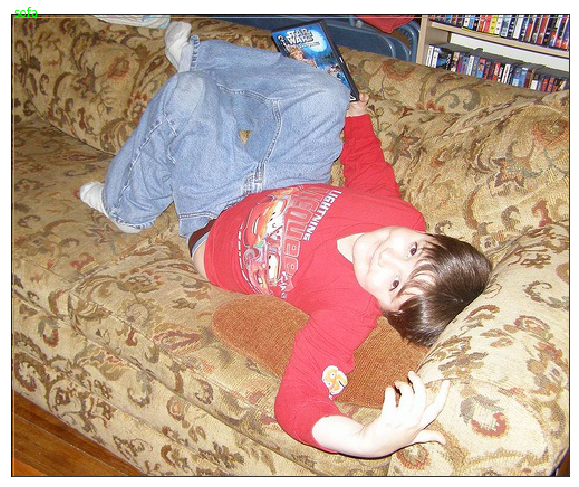

In [6]:
voc.utils.show_annotation(filtered)

Awesome. So now, I have annotations, and images. I want to turn these into iterables I can pass to a neural network.

In order to finetune the model, I want to remove the last few layers, and replace them with a 4 dimensional output which isn't put through a softmax (since this is no longer a classification problem).

In [7]:
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
total_dataset = voc.datasets.VOCDataset()

Now that we know the size of the dataset, we can use this to create a mask

In [9]:
train_mask = np.random.rand(len(total_dataset)) < 0.8
val_mask = ~train_mask

In [10]:
train_images = voc.datasets.ImageDataset(mask=train_mask, normalizer='imagenet', resize=(224, 224), device=device)

In [11]:
label2class = train_images.get_labels_from_classes()

In [12]:
val_images = voc.datasets.ImageDataset(mask=val_mask, normalizer='imagenet', resize=(224, 224),
                                       label2class=label2class, device=device)

In [13]:
train_images_dl = DataLoader(train_images, batch_size=128, shuffle=True)
val_images_dl = DataLoader(val_images, batch_size=128)

Optionally, add a `.cuda()` call if you are running stuff on a GPU.

In [14]:
sod = voc.models.SODNet(num_classes = len(label2class)).cuda()

In [15]:
def get_weight(model, inputs):
    """
    Calculate the scalar factor which allows
    the weights to be combined in a comparable manner
    """
    
    # first, lets define our losses
    bb_criterion = torch.nn.modules.loss.L1Loss()
    label_criterion = torch.nn.modules.loss.CrossEntropyLoss()
    
    im, bb, lab = inputs
    
    output_bb, output_labels = model(im)
    
    bb_loss = bb_criterion(output_bb, bb.float())
    label_loss = label_criterion(output_labels, lab.long())
    
    return abs(float((label_loss / bb_loss).detach()))

In [16]:
loss_weight = get_weight(sod, next(iter(train_images_dl)))

In [17]:
loss_weight

0.037280309945344925

In [18]:
bb_criterion = torch.nn.modules.loss.L1Loss()
label_criterion = torch.nn.modules.loss.CrossEntropyLoss()

In [19]:
def accuracy(output_labels, true_labels, device):
    """
    For a more interpretable metric, calculate the accuracy of the predictions
    """
    output_labels = torch.nn.functional.softmax(output_labels, dim=1).argmax(dim=1)
    correct = torch.eq(true_labels, output_labels).sum().item()
    accuracy = correct / output_labels.shape[0]
    return accuracy

In [20]:
num_epochs = 3
running_loss = 0

In [21]:
parameters_to_update = len([parameters for name, parameters in sod.named_parameters() if 'finetune' in name])

In [22]:
optimizer = torch.optim.Adam(list(sod.parameters())[:-parameters_to_update])

In [23]:
for epoch in range(num_epochs):
        print('Epoch %d / %d' % (epoch + 1, num_epochs))

        # set model to train
        sod.train()

        # Keep track of my loss, so I can display it
        running_loss = 0.0
        n_batches = 0.0
        
        # for every new epoch, lets start training a new layer
        parameters_to_update += epoch
        optimizer = torch.optim.Adam(list(sod.parameters())[:-parameters_to_update])

        # Iterate through my batches
        for batch_number, batch in (enumerate(tqdm(train_images_dl))):
            # Zero the gradients of my optimizer - 'reset' it
            optimizer.zero_grad()
            
            ims, target_bb, target_label = batch
            output_bb, output_labels = sod(ims)
            
            bb_loss = bb_criterion(output_bb, target_bb.float())
            label_loss = label_criterion(output_labels, target_label.long())
            
            loss = label_loss + (loss_weight * bb_loss)
            
            loss.backward()
            optimizer.step()
            # For display purposes:
            running_loss += loss.data.item()
        
        # now, lets see how we did on the validation set
        sod.eval()
        total_bb_loss = 0
        total_label_loss = 0
        accuracy_list = []
        for batch_number, batch in (enumerate(val_images_dl)):
            val_ims, val_bb, val_lab = batch
            output_bb, output_labels = sod(val_ims)
        
            val_bb_loss = bb_criterion(output_bb, val_bb.float())
            val_label_loss = label_criterion(output_labels, val_lab.long())
            total_bb_loss += val_bb_loss.item()
            total_label_loss += val_label_loss.item()
            
            accuracy_list.append(accuracy(output_labels, val_lab, device))
        
        accuracy_mean = np.array(accuracy_list).mean()
        print ('Validation bounding box loss: {}'.format(val_bb_loss))   
        print ('Validation label loss: {}'.format(val_label_loss))
        print ('Validation label accuracy: {}%'.format(accuracy_mean))

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 / 3


  0%|          | 0/32 [00:00<?, ?it/s]

Validation bounding box loss: 26.309324264526367
Validation label loss: 1.7755687236785889
Validation label accuracy: 0.4146831191588785%
Epoch 2 / 3


  0%|          | 0/32 [00:00<?, ?it/s]

Validation bounding box loss: 27.281856536865234
Validation label loss: 2.1047518253326416
Validation label accuracy: 0.3127555490654206%
Epoch 3 / 3


100%|██████████| 32/32 [01:12<00:00,  2.27s/it]


Validation bounding box loss: 24.116334915161133
Validation label loss: 1.6569061279296875
Validation label accuracy: 0.4144914573598131%


Finally, lets check how the model does on real data!

In [24]:
from voc.utils import denormalize, plot_image

In [25]:
imagenet = train_images.get_normalizer()

In [35]:
sod.eval();

In [27]:
ims, bbs, labels = next(iter(val_images_dl))

In [28]:
output_bb, output_labels = sod(val_ims)

Lets take the first 4 images to plot

In [29]:
bb_to_plot = output_bb[:4].detach().cpu().numpy()
lab_to_plot = torch.nn.functional.softmax(output_labels[:4], dim=1).argmax(dim=1).detach().cpu().numpy()
im_to_plot = val_ims[:4].detach().cpu().numpy()

In [30]:
class2label = {idx: val for val, idx in label2class.items()}

In [31]:
labels_to_plot = [class2label[idx] for idx in lab_to_plot]

In [32]:
denormed_ims = [denormalize(im, imagenet['mean'], imagenet['std']) for im in im_to_plot]

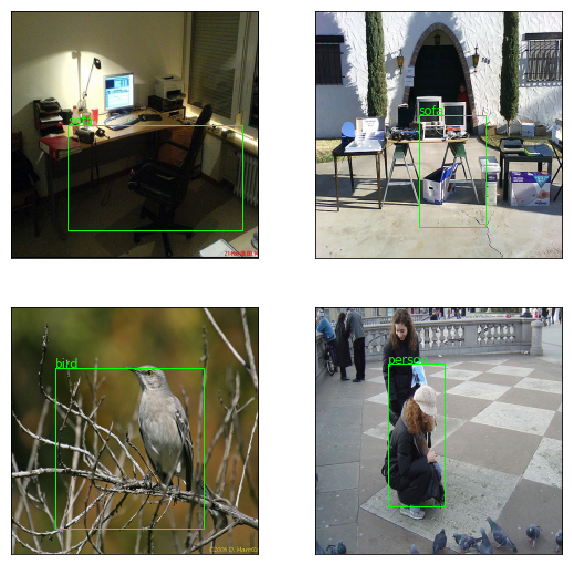

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for image, bb, label, ax in zip(denormed_ims, bb_to_plot, labels_to_plot, axes.reshape(-1)):
    plot_image(image, [bb], [label], ax=ax)
plt.show()